Presented by: Reza Saadatyar <br/>
E-mail: Reza.Saadatyar92@gmail.com

**Importing the required Libraries**

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing, model_selection, linear_model

**Functions**

In [12]:
# =============================================== Preparing data =========================================================
def preparing_data(data, labels):
    if data.shape[0] < data.shape[1]:
        data = data.T
    Labels = preprocessing.LabelEncoder()
    Labels = Labels.fit_transform(labels)
    return data, Labels
 
# ==================================================== Filtering =========================================================
def filtering(data, f_low, f_high, order, fs, filter_type="low"):
    if data.ndim > 1:
        if data.shape[0] > data.shape[1]:
            data = data.T
            
    f_low = f_low / (fs / 2)
    f_high = f_high / (fs / 2)
    
    if filter_type == "low":
        b, a = signal.butter(order, f_low, btype='low')
    elif filter_type == "high":
        b, a = signal.butter(order, f_high, btype='high')
    elif filter_type == "bandpass":
        b, a = signal.butter(order, [f_low, f_high], btype='bandpass')
    elif filter_type == "bandstop":
        b, a = signal.butter(order, [f_low, f_high], btype='bandstop')
    filtered_data = signal.filtfilt(b, a, data)
    
    return filtered_data.T

# ================================================= Plot data ============================================================
def plot_data(filtered_data, fs=None, first_point=0, last_point=100, val_ylim='', size_fig=(7,5), title='', display_figure="off"):
    
    if display_figure == "on":
        if filtered_data.shape[0] < filtered_data.shape[1]:
            filtered_data = filtered_data.T
            
        filtered_data = filtered_data[first_point:last_point,:]
        
        std = np.sort(np.std(filtered_data, axis=0))
        if len(std) > 100:
            std = np.mean(std[1:len(std)-1])
        else:
            std = np.mean(std)
        
        _, axs = plt.subplots(nrows=1, sharey='row', figsize=size_fig)
        offset = np.arange(filtered_data.shape[1]*std*val_ylim, 1, -std*val_ylim)
      
        if fs is not None and np.array(fs) > 0:
            time = (np.linspace(start=first_point/fs, stop=last_point/fs, num=len(filtered_data))).flatten()
            line = axs.plot(time, filtered_data + offset, linewidth=1)
            axs.set_xlabel('Time (sec)', fontsize=10)
        else:
            line = axs.plot(filtered_data + offset, linewidth=1)
            axs.set_xlabel('sample', fontsize=10)
        
        axs.set_title(title, fontsize=10)
        axs.set_yticks(offset)
        axs.set_yticklabels(["ch" + str(i) for i in range(1, filtered_data.shape[1] + 1)],  weight='bold')
        axs.tick_params(axis='x', labelsize=9)
        axs.tick_params(axis='y', labelsize=8)
        axs.set_ylabel('Channels', fontsize=10)
        axs.tick_params(axis='y', color='k', labelcolor='k')
        axs.grid(False)
        ytick_labels = plt.gca().get_yticklabels()
        for i, label in enumerate(ytick_labels):
            # line[i].set_color(line[i].get_color())
            label.set_color(line[i].get_color())
            
        axs.autoscale(enable=True, axis="x",tight=True)
        min = np.min(np.min(filtered_data + offset, axis=0))
        max = np.max(np.max(filtered_data + offset, axis=0))
        axs.set_ylim(min + min*0.02, max + max*0.01)

# ============================================== Data normalization ======================================================                          
def data_normalization(x_train, x_test, method=1):
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        
    if method == 1:
        norm = preprocessing.MinMaxScaler()
    elif method == 2:
        norm = preprocessing.StandardScaler()
        
    x_train = norm.fit_transform(x_train)
    x_test = norm.transform(x_test)
    
    return x_train, x_test



**1. Load data**

In [13]:
method = 1
if method==1:
   x, y = datasets.make_classification(n_samples=1000,      # Number of samples in the dataset
                                       n_features=5,       # Number of total features
                                       n_informative=2,    # Number of informative features
                                       n_redundant=0,      # Number of redundant features
                                       n_classes=2,        # Number of classes in the dataset (binary classification in this case)
                                       random_state=1)     # Seed for reproducibility)
   # print(f"{x.shape=},\n{x=},\n{y=}")
elif method==2:
   iris = datasets.load_iris()
   x = iris.data
   y = iris.target
   # print(f"{iris.data.shape=},\n{iris.feature_names=},\n{iris.target_names=},\n{iris.data=},\n{iris.target}")

**2. Preparing the data**

In [14]:
data, labels = preparing_data(x, y)

**3. Detect the important feature**

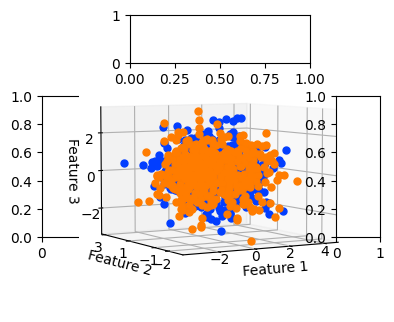

In [117]:
lab = np.unique(labels)
colors = np.array(sns.color_palette("bright", len(lab))) 
fig = plt.figure(figsize=(4, 3))

# ax = fig.add_axes((0.16, 0.76, 0.62, 0.14))
# pos1 = ax.get_position()
# fig.suptitle("Raw data", fontsize=11, y=pos1.y0 + 0.2)

if data.shape[1] == 1:
   
   ax2 = fig.add_axes((0.15, 0.1, 0.64, 0.65))
   for i in range(0, len(lab)):
      _, bins = np.histogram(data[labels == lab[i], 0], density=True)
      ax.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=1.5, color=colors[i, :])
      ax.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.55)

      tim = np.linspace(np.min(data[labels == lab[i], 0]), np.max(data[labels == lab[i], 0]), num=len(data[labels == lab[i], 0]), retstep=True)
      ax2.plot(tim[0], data[labels == lab[i], 0], '.', markersize=10, color=colors[i, :], label=lab[i])
      pos1 = ax.get_position()
      ax2.legend(title='Class', ncol=3, handlelength=0.8, handletextpad=0.2), ax2.set(xlabel='Feature 1')
elif data.shape[1] < 3:
   ax2 = fig.add_axes((0.15, 0.1, 0.64, 0.65))
   ax3 = fig.add_axes((0.8, 0.11, 0.14, 0.62))
   for i in range(0, len(lab)):
         _, bins = np.histogram(data[labels == lab[i], 0], density=True)
         ax.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=1.5, color=colors[i, :])
         ax.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.55)

         ax2.plot(data[labels == lab[i], 0], data[labels == lab[i], 1], '.', markersize=12, color=colors[i, :], label=lab[i])

         _, bins = np.histogram(data[labels == lab[i], 1], density=True)
         ax3.plot(stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), bins, linewidth=1.5, color=colors[i, :])
         ax3.fill_betweenx(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), 0, alpha=0.6, color=colors[i, :])
         
         ax2.legend(title='Class', ncol=3, handlelength=0.8, handletextpad=0.2), ax2.set(xlabel='Feature 1', ylabel='Feature 2')

elif data.shape[1] > 2:
   
   ax1 = fig.add_axes((0.07, 0.2, 0.12, 0.47))
   ax2 = fig.add_axes((0.05, -0.05, 0.9, 0.9), projection="3d")
   ax = fig.add_axes((0.29, 0.78, 0.45, 0.16))
   ax3 = fig.add_axes((0.806, 0.2, 0.11, 0.47))

   for i in range(0, len(lab)):
         # _, bins = np.histogram(data[labels == lab[i], 0], density=True)
         # ax.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=2.5, color=colors[i, :])
         # ax.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.6, color=colors[i, :])

         # _, bins = np.histogram(data[labels == lab[i], 1], density=True)
         # ax1.plot(-stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), bins, linewidth=2.5, color=colors[i, :])
         # ax1.fill_betweenx(bins, 0, -stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), alpha=0.6, color=colors[i, :])

         ax2.plot3D(data[labels == lab[i], 0], data[labels == lab[i], 1], data[labels == lab[i], 2], '.', markersize=10, color=colors[i, :], label=lab[i])

         # _, bins = np.histogram(data[labels == lab[i], 2], density=True)
         # ax3.plot(stats.norm.pdf(bins, np.mean(data[labels == lab[i], 2]), np.std(data[labels == lab[i], 2])), bins, linewidth=2.5, color=colors[i, :])
         # ax3.fill_betweenx(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 2]), np.std(data[labels == lab[i], 2])), 0, alpha=0.6, color=colors[i, :])
         

   ax2.view_init(5, -120), 
   ax2.margins(x=0), ax2.margins(y=0), ax2.margins(z=0), #ax.set_zorder(1), 
   ax2.yaxis.set_ticks(np.linspace(ax2.get_yticks()[1], ax2.get_yticks()[-2], int(len(ax2.get_yticks()) / 2), dtype='int'))
  
   ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-7.5)
   ax2.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-4)
   ax2.tick_params(axis='z', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-3)
   ax2.set_xlabel('Feature 1', labelpad=-8, fontsize=10), ax2.set_ylabel('Feature 2', labelpad=-8, fontsize=10),  ax2.set_zlabel('Feature 3', labelpad=-8, fontsize=10)
   # ax2.tick_params(axis="x", which='both', labelleft=True, labelright=False, pad=0)
   # ax2.legend(title='Class', loc=3, ncol=3, handlelength=0.8, handletextpad=0.2, fontsize=8)  # bbox_to_anchor=(0.1, pos1.x1-0.02, pos1.x1-0.02, 0)
   # ax2.spines[['top', 'right', 'left','bottom']].set_visible(True)
   # ax2.dist = 7
   # ax2.set_proj_type('persp')  # 'persp' for perspective projection, 'ortho' for orthographic
   
#    
#    ax2.
#    fig.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0, hspace=0),
#    
#    
#    pos1 = ax.get_position()
#    pos2 = ax2.get_position()
#    ax.set_position([0.29, np.abs(pos1.y0 - pos2.y0), 0.45, 0.16])
#    

#    

# # 
# ax2.autoscale(enable=True, axis="x",tight=True)
# ax2.grid(visible="off")

(None,)

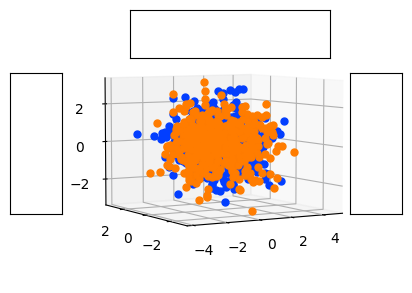

In [149]:
lab = np.unique(labels)
colors = np.array(sns.color_palette("bright", len(lab))) 
fig = plt.figure(figsize=(4, 3))
if data.shape[1] > 2:
   ax2 = fig.add_axes((0.02, -0.05, 0.9, 0.9), projection="3d")
   ax1 = fig.add_axes((-0.05, 0.18, 0.13, 0.47))
   ax = fig.add_axes((0.25, 0.7, 0.5, 0.16))
   ax3 = fig.add_axes((0.8, 0.18, 0.13, 0.47))

   for i in range(0, len(lab)):
      
      ax2.plot3D(data[labels == lab[i], 0], data[labels == lab[i], 1], data[labels == lab[i], 2], '.', markersize=10, color=colors[i, :], label=lab[i])
   
   ax2.view_init(5, -120)
   ax1.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False), #ax1.spines[['top', 'left', 'bottom']].set_visible(False)
ax.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False), #ax.spines[['top', 'right', 'left']].set_visible(False)
ax3.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False), #x3.spines[['top', 'right', 'bottom']].set_visible(False)

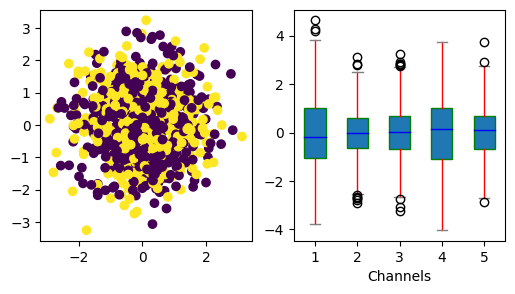

In [32]:
_, axs= plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].scatter(data[:,1], data[:,2], c=labels)
axs[1].boxplot(data, boxprops=dict(color='green'), whiskerprops=dict(color='red'), medianprops=dict(color='blue'), capprops=dict(color='gray'), patch_artist=True)
axs[1].set_xlabel("Channels")
plt.autoscale(axis="x", tight=True, enable=True)

**3. Filtering**<br/>

`Fs > f_high > f_low`

In [14]:
data.shape

(500, 3)

In [43]:
filtered_data = filtering(data, f_low=3, f_high=10, order=3, fs=50, filter_type="low")    # btype:'low','high','bandpass','bandstop'
plot_data(filtered_data, fs=None, first_point=0, last_point=500, val_ylim=3, size_fig=(7,5), title='filtered_data', display_figure="off")

**4. Split data**

In [78]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.3, random_state=42)

**5. Data normalization**

In [79]:
x_train, x_test = data_normalization(x_train, x_test, method=2)   # method 1: MinMaxScaler, method 2: StandardScaler